In [1]:
import argparse
from pathlib import Path
from tqdm import tqdm
import torch
from einops import repeat
from PIL import Image
from torchvision.utils import make_grid, save_image
from dalle_pytorch import DiscreteVAE, OpenAIDiscreteVAE, VQGanVAE1024, DALLE
from dalle_pytorch.tokenizer import tokenizer, HugTokenizer
import pandas as pd
import os
import clip
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import time

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


def generate_images(dalle_path, text, num_images, batch_size, top_k, bpe_path):
    tokenizer = HugTokenizer(bpe_path)
    dalle_path = Path(dalle_path)
    load_obj = torch.load(str(dalle_path))
    dalle_params, vae_params, weights = load_obj.pop('hparams'), load_obj.pop('vae_params'), load_obj.pop('weights')
    dalle_params.pop('vae', None) # cleanup later
    vae = VQGanVAE1024()
    dalle = DALLE(vae = vae, **dalle_params).cuda()
    dalle.load_state_dict(weights)

    # generate images
    image_size = vae.image_size
    text = tokenizer.tokenize([text], dalle.text_seq_len).cuda()
    text = repeat(text, '() n -> b n', b = num_images)
    outputs = []
    for text_chunk in tqdm(text.split(batch_size)):
        output = dalle.generate_images(text_chunk, filter_thres = top_k, temperature=1.0)
        outputs.append(output)
    return torch.cat(outputs)


def save_outputs(outputs, folder):
    odir = Path(folder)
    odir.mkdir(parents = True, exist_ok = True)
    for i, image in tqdm(enumerate(outputs), desc = 'saving images'):
        save_image(image, odir / f"{i}.jpg", normalize=True)


def prepro(folder, im):
    return preprocess(Image.open(f"{folder}/{im}.jpg")).unsqueeze(0).to(device)


def read_images_for_ranking(folder, num_images):
    return torch.cat(tuple([prepro(folder, x) for x in range(num_images)]))


def read_images_for_showing(folder, num_images):
    t = transforms.ToTensor()
    images = torch.stack(tuple([t(Image.open(f"{folder}/{x}.jpg")) for x in range(num_images)]))
    return images.cpu().numpy()


def clip_ranking(images, caption):
    image = F.interpolate(images, size=224)
    text = clip.tokenize(caption).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        _, logits_per_text = model(image, text)
        probs = logits_per_text.softmax(dim=-1).cpu().numpy()
    probabilities = probs[0]
    return probabilities, logits_per_text.cpu().numpy()[0]


def show_reranking(images, scores, sort=True):
    img_shape = images.shape
    if sort:
        scores_sort = scores.argsort()
        scores = scores[scores_sort[::-1]]
        images = images[scores_sort[::-1]]

    rows = 4
    cols = img_shape[0] // 4
    img_idx = 0
    figs = []
    for col in range(cols):
        fig, axs = plt.subplots(1, rows, figsize=(20,20))
        plt.subplots_adjust(wspace=0.01)
        for row in range(rows):
            tran_img = np.transpose(images[img_idx], (1,2,0))
            axs[row].imshow(tran_img, interpolation='nearest')
            axs[row].set_title("{}%".format(np.around(scores[img_idx]*100, 2)))
            axs[row].set_xticks([])
            axs[row].set_yticks([])
            img_idx += 1
        fig.canvas.draw()
        rgba_buf = fig.canvas.buffer_rgba()
        (w,h) = fig.canvas.get_width_height()
        print(w,h)
        rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h,w,4))
        figs.append(rgba_arr)
    return figs
    #plt.imsave("testim2.png",np.concatenate(tuple([x.canvas.renderer.buffer_rgba() for x in figs]),axis=0))
    

In [2]:
text = "this colorful bird has a yellow breast, with a black crown and a black cheek patch"
num_images = 8
batch_size = 8
top_k = 0.9
bpe_path = "./cub200_bpe_vsize_7800.json"

def get_model_output(dalle_path):
    torch.cuda.empty_cache()
    model, preprocess = clip.load("ViT-B/32", device=device)
    ims = generate_images(dalle_path, text, num_images, batch_size, top_k, bpe_path)
    folder = f"new_outputs/{dalle_path[:-3]}"
    save_outputs(ims, folder)
    rereadims = read_images_for_ranking(folder, num_images)
    probs, logits = clip_ranking(rereadims, text)
    np_images = read_images_for_showing(folder, num_images)
    figs = show_reranking(np_images, probs)
    return figs, probs, logits

def save_figs_to_file(figs, logits, dalle_path):
    plt.imsave(
        f"new_outputs/{np.mean(logits)}-{dalle_path.replace('/','_')}.png",
        np.concatenate(tuple([x for x in figs]),axis=0)
        #np.concatenate(tuple([x.canvas.renderer.buffer_rgba() for x in figs]),axis=0)
    )

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


100%|██████████| 1/1 [00:12<00:00, 12.58s/it]
saving images: 8it [00:00, 34.06it/s]


1440 1440
1440 1440


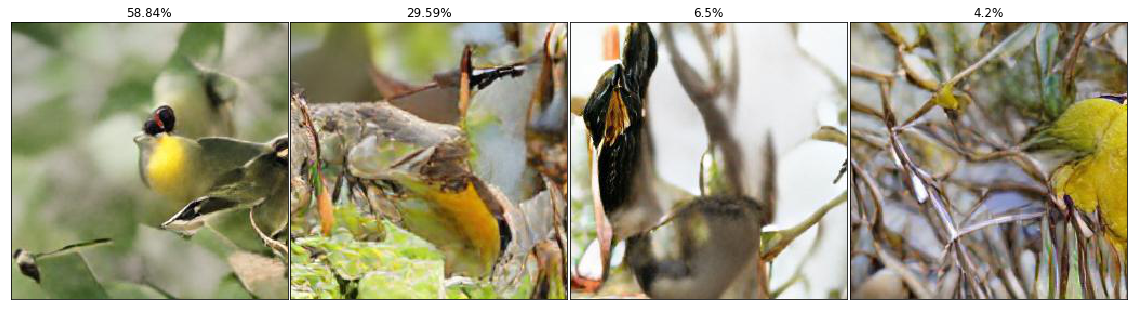

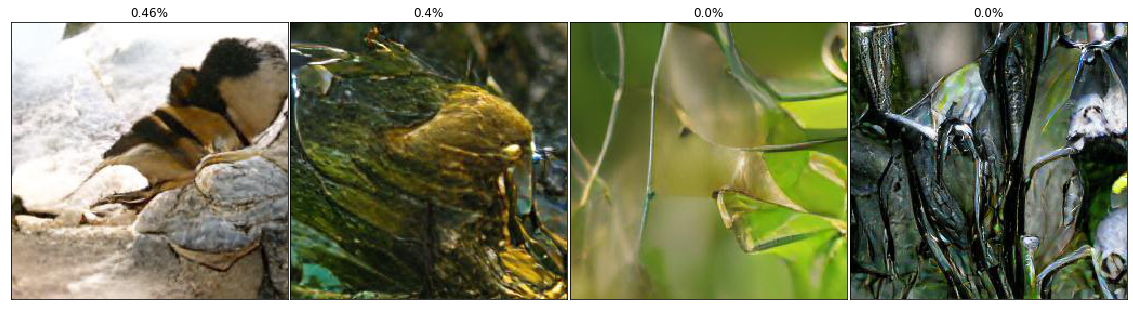

In [3]:
dalle_paths = [
    "grateful-energy-30/grateful-energy-30-50.pt",
    #"grateful-energy-30/grateful-energy-30-55.pt",
]

for d in dalle_paths:
    figs, probs, logits = get_model_output(d)
    save_figs_to_file(figs, logits, d)

In [4]:
figs, probs, logits = get_model_output(d)
time.sleep(1)
save_figs_to_file(figs, logits, d)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


  0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
figs[0][710][720]

In [ ]:
f = show_reranking(np_images, probs)

In [ ]:
f[0].mean()

In [9]:
figs[0].shape

(1440, 1440, 4)